# Assignment 1 – Trading Strategy and Candlestick Analysis

# Assignment 1 – Trading Strategy using Technical Indicators

In this notebook I have tried to build a simple trading strategy using some
technical indicators studied in class. The strategy is tested on BTC-USD
historical data. 


## 1. Data Loading and Preprocessing

We begin by loading the historical BTC-USD OHLCV data and performing basic
preprocessing to prepare it for indicator calculation and backtesting.


In [96]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

print("All required libraries are successfully imported.")

All required libraries are successfully imported.


In [97]:
# download BTC-USD data
df = yf.download(
    "BTC-USD",
    start="2022-01-01",
    end="2025-01-01",
    interval="1d"
)

df.head()



C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2451866210.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2022-01-01,47686.812500,47827.312500,46288.484375,46311.746094,24582667004
2022-01-02,47345.218750,47881.406250,46856.937500,47680.925781,27951569547
2022-01-03,46458.117188,47510.726562,45835.964844,47343.542969,33071628362
2022-01-04,45897.574219,47406.546875,45752.464844,46458.851562,42494677905
2022-01-05,43569.003906,46929.046875,42798.222656,45899.359375,36851084859


In [98]:
df = df.dropna()
df.reset_index(inplace=True)
df.columns = df.columns.get_level_values(0)


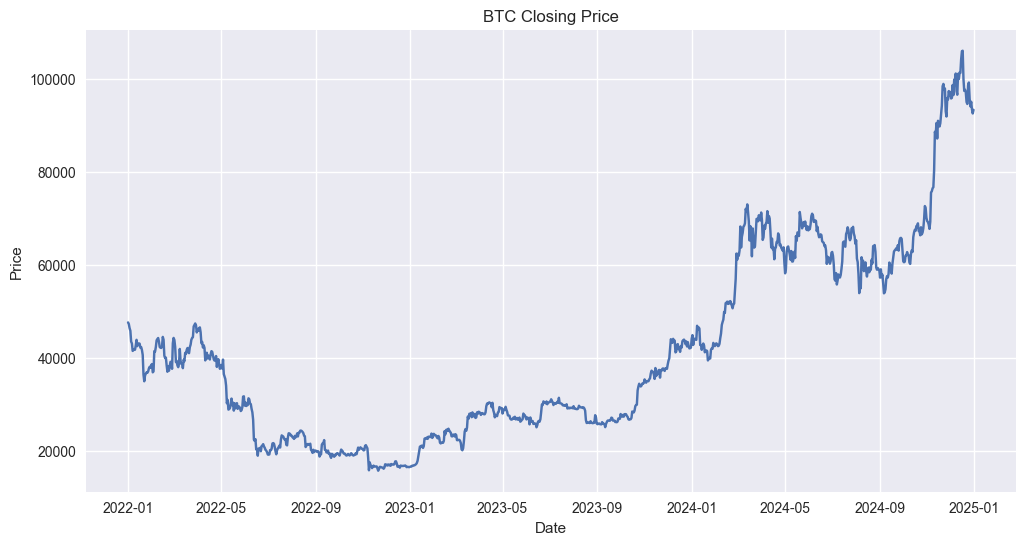

In [99]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'])
plt.title('BTC Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


## 2. Technical Indicators

In this section, we compute commonly used technical indicators that capture
momentum, volume-based behavior, and trend direction.
These indicators are later used to generate buy and sell signals. 


### 2.1 Rate of Change (ROC)

Rate of Change measures price momentum by calculating the percentage change
in price over a fixed lookback period. Positive values indicate bullish momentum,
while negative values indicate bearish momentum.


In [100]:
n = 14  # lookback period

df['ROC'] = 0.0

for i in range(n, len(df)):
    df['ROC'].iloc[i] = (
        (df['Close'].iloc[i] - df['Close'].iloc[i - n]) /
        df['Close'].iloc[i - n]
    ) * 100


C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\3193289356.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROC'].iloc[i] = (
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\3193289356.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROC'].iloc[i] = (
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\3193289356.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROC'].iloc[i] = (
C:\Users\harsh\AppData\Local\Temp\

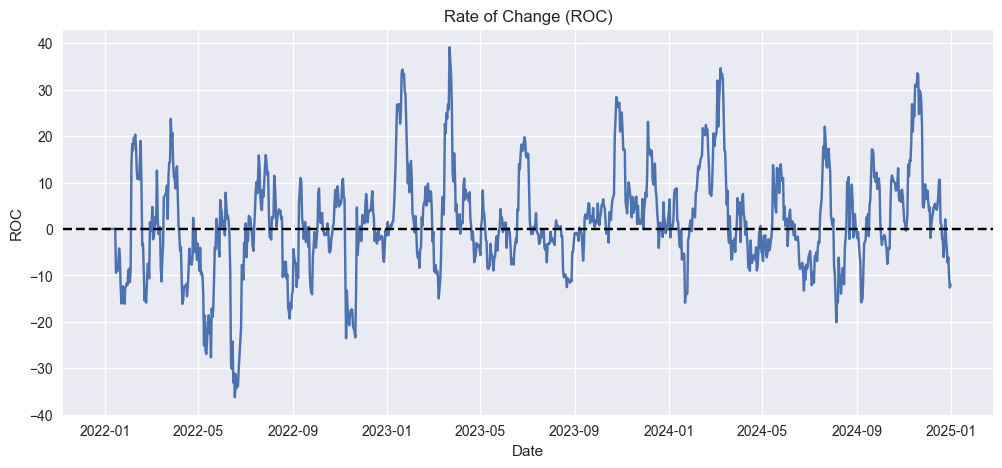

In [101]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['ROC'])
plt.axhline(0, color='black', linestyle='--')
plt.title('Rate of Change (ROC)')
plt.xlabel('Date')
plt.ylabel('ROC')
plt.show()


### 2.2 Negative Volume Index (NVI)

Negative Volume Index (NVI) is a volume based indicator. It updates only on
days when the trading volume decreases compared to the previous day. The
idea is that smart or informed traders usually trade during low volume days.



In [102]:
df['NVI'] = 0.0
df['NVI'].iloc[0] = 1000  # starting value

for i in range(1, len(df)):
    if df['Volume'].iloc[i] < df['Volume'].iloc[i - 1]:
        price_change = (
            (df['Close'].iloc[i] - df['Close'].iloc[i - 1]) /
            df['Close'].iloc[i - 1]
        )
        df['NVI'].iloc[i] = df['NVI'].iloc[i - 1] * (1 + price_change)
    else:
        df['NVI'].iloc[i] = df['NVI'].iloc[i - 1]


C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2789645448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NVI'].iloc[0] = 1000  # starting value
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2789645448.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NVI'].iloc[i] = df['NVI'].iloc[i - 1]
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2789645448.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NVI'].ilo

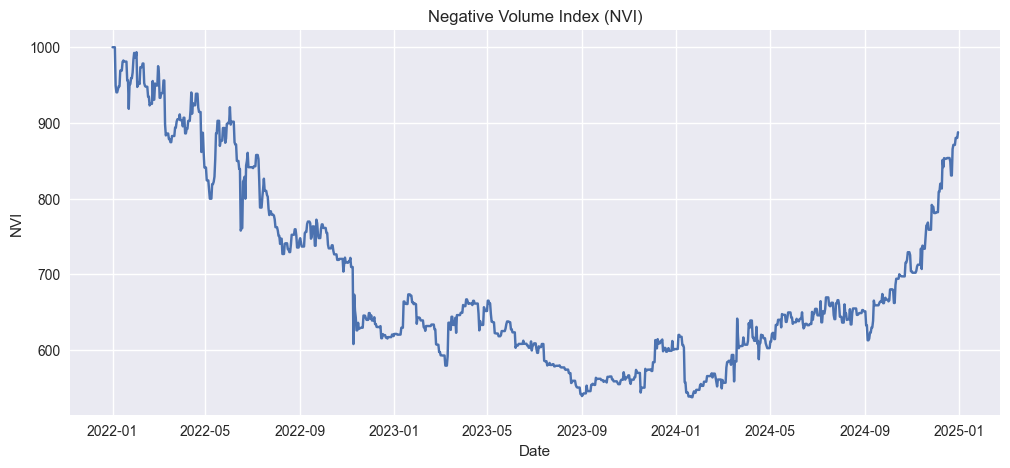

In [103]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['NVI'])
plt.title('Negative Volume Index (NVI)')
plt.xlabel('Date')
plt.ylabel('NVI')
plt.show()



It can be observed that NVI remains flat for many days. This is because the
indicator only updates when volume falls, which does not happen frequently
in daily cryptocurrency data.


### 2.3 Parabolic SAR

Parabolic SAR is a trend following indicator. It places points above or below
the price which helps in identifying trend direction and possible reversals.
It is also commonly used as a trailing stop-loss indicator.


In [104]:
af = 0.02
af_max = 0.2


In [105]:
df['PSAR'] = df['Low'].iloc[0]
bullish = True
ep = df['High'].iloc[0]
acc = af

for i in range(1, len(df)):
    prev_psar = df['PSAR'].iloc[i - 1]
    
    if bullish:
        psar = prev_psar + acc * (ep - prev_psar)
        if df['Low'].iloc[i] < psar:
            bullish = False
            psar = ep
            ep = df['Low'].iloc[i]
            acc = af
        else:
            if df['High'].iloc[i] > ep:
                ep = df['High'].iloc[i]
                acc = min(acc + af, af_max)
    else:
        psar = prev_psar + acc * (ep - prev_psar)
        if df['High'].iloc[i] > psar:
            bullish = True
            psar = ep
            ep = df['High'].iloc[i]
            acc = af
        else:
            if df['Low'].iloc[i] < ep:
                ep = df['Low'].iloc[i]
                acc = min(acc + af, af_max)
    
    df['PSAR'].iloc[i] = psar


C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\580458372.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PSAR'].iloc[i] = psar
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\580458372.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PSAR'].iloc[i] = psar
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\580458372.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PSAR'].iloc[i] = psar
C:\Users\harsh\AppData

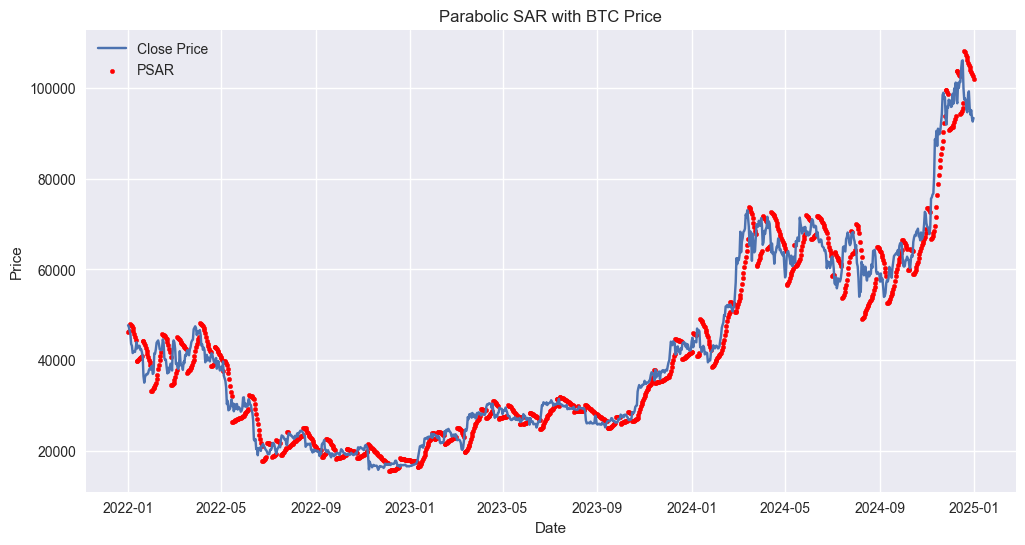

In [106]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.scatter(df['Date'], df['PSAR'], s=10, color='red', label='PSAR')
plt.legend()
plt.title('Parabolic SAR with BTC Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [107]:
df[['Close', 'ROC', 'NVI', 'PSAR']].tail()


Price,Close,ROC,NVI,PSAR
1091,94164.859375,-7.189485,870.943045,104077.844969
1092,95163.929688,-6.124945,880.183577,103601.738358
1093,93530.226562,-10.324644,880.183577,103144.676011
1094,92643.210938,-12.625241,880.183577,102705.896158
1095,93429.203125,-11.976000,887.651123,102022.570357


## 3. Trading Strategy and Signal Generation

A simple rule based strategy is created using ROC and Parabolic SAR. The idea
is to take trades only when both momentum and trend indicators agree. This
helps in reducing false signals.


Trading Rules:
- Buy when ROC is positive and price is above Parabolic SAR.
- Sell when ROC is negative and price is below Parabolic SAR.



In [108]:
df['signal'] = 0

for i in range(1, len(df)):
    if df['ROC'].iloc[i] > 0 and df['Close'].iloc[i] > df['PSAR'].iloc[i]:
        df['signal'].iloc[i] = 1
    elif df['ROC'].iloc[i] < 0 or df['Close'].iloc[i] < df['PSAR'].iloc[i]:
        df['signal'].iloc[i] = -1


C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2287130401.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].iloc[i] = -1
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2287130401.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].iloc[i] = -1
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2287130401.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].iloc[i] = -1
C:\Users\harsh\AppData

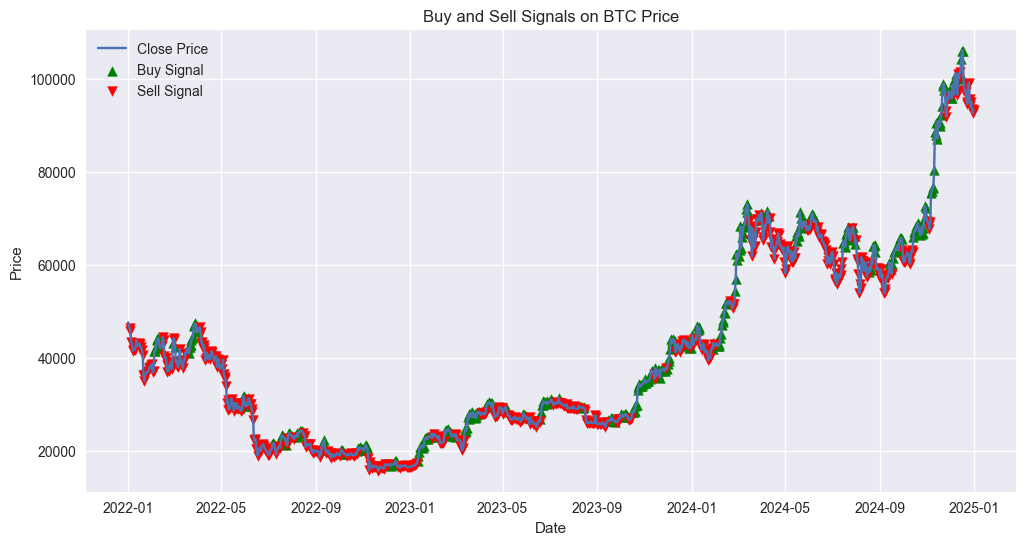

In [109]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')

plt.scatter(
    df[df['signal'] == 1]['Date'],
    df[df['signal'] == 1]['Close'],
    marker='^',
    color='green',
    label='Buy Signal'
)

plt.scatter(
    df[df['signal'] == -1]['Date'],
    df[df['signal'] == -1]['Close'],
    marker='v',
    color='red',
    label='Sell Signal'
)

plt.legend()
plt.title('Buy and Sell Signals on BTC Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


###Position Tracking

In [110]:
df['position'] = 0
pos = 0

for i in range(1, len(df)):
    if df['signal'].iloc[i] == 1 and pos == 0:
        pos = 1
    elif df['signal'].iloc[i] == -1 and pos == 1:
        pos = 0

    df['position'].iloc[i] = pos


C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\3555993074.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'].iloc[i] = pos
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\3555993074.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'].iloc[i] = pos
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\3555993074.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'].iloc[i] = pos
C:\Users\h

Position column indicates whether the strategy is holding Bitcoin or not at a particular time.

## Stratergy Returns

The strategy is backtested using historical data. To avoid look-ahead bias,
positions are shifted by one day. Strategy returns are compared with a
buy-and-hold approach for BTC.


In [111]:
df['daily_return'] = df['Close'].pct_change()
df['strategy_return'] = df['daily_return'] * df['position'].shift(1)
df['equity_curve'] = (1 + df['strategy_return']).cumprod()


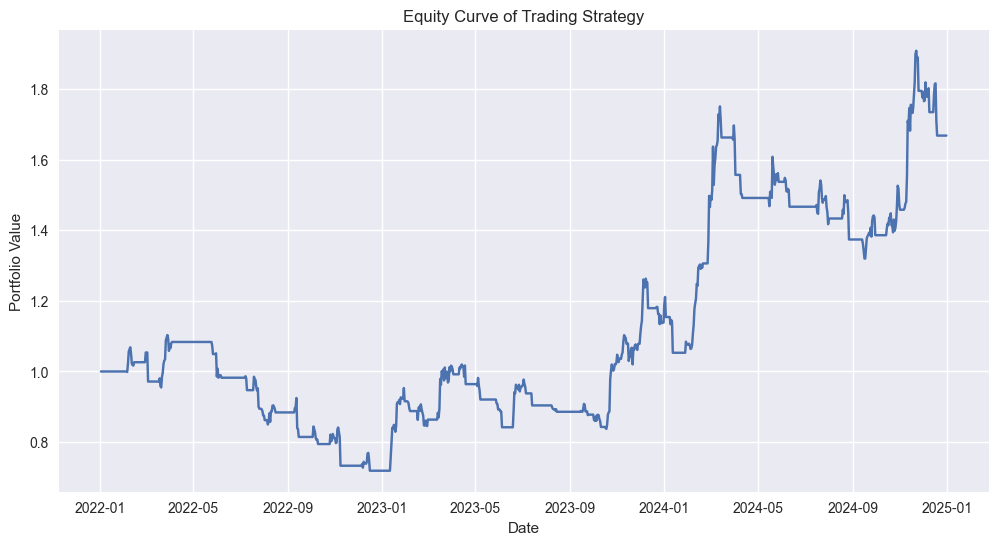

In [112]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['equity_curve'])
plt.title('Equity Curve of Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()


Equity curve shows the cumulative performance of the trading strategy over time

From the plot, it can be seen that the strategy behaves differently compared
to buy-and-hold. The strategy avoids some large drawdowns but also misses
some strong upward movements.


## 5. Performance Metrics

The performance of the strategy is evaluated using different metrics such as
total return, maximum drawdown and Sharpe ratio. These metrics help in
understanding both profitability and risk.


In [113]:
sharpe_ratio = (df['strategy_return'].mean() / df['strategy_return'].std()) * np.sqrt(252)

rolling_max = df['equity_curve'].cummax()
drawdown = df['equity_curve'] / rolling_max - 1
max_drawdown = drawdown.min()

total_profit = df['equity_curve'].iloc[-1] - 1

print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Total Profit:", total_profit)


Sharpe Ratio: 0.5887101217935222
Maximum Drawdown: -0.3482384837939443
Total Profit: 0.6678352459458068


Although the total return of the strategy is lower than the market, the
drawdown is reduced. This shows that the strategy focuses more on risk control
rather than maximum profit.


Sharpe ratio is used to measure risk adjusted returns. Maximum drawdown shows the worst loss from peak. Total profit indicates overall return of strategy.

## 6. Optimization Discussion

The performance of the strategy can possibly be improved by tuning the ROC
lookback period or adjusting the acceleration factor of Parabolic SAR.
However, too much optimization may lead to overfitting and poor performance
on unseen data.


## 7. Question 2.3 – Hammer Candlestick Pattern

A Hammer candlestick is a single candle pattern which usually appears after
a price decline. It has a small real body and a long lower shadow, indicating
rejection of lower prices.


In this analysis, a Hammer is defined using the ratio between shadow length
and real body. The lower shadow is required to be at least twice the size of
the real body, while the upper shadow should be small.
LowerShadow ≥ 2 × Body
UpperShadow ≤ 0.3 × Body
Body > 0



In [114]:
df['Hammer'] = 0


Using the above definition, multiple Hammer patterns are detected in the data.
A few sample Hammer candles are plotted below to visually verify the pattern.


In [115]:
for i in range(len(df)):
    
    open_price = df['Open'].iloc[i]
    close_price = df['Close'].iloc[i]
    high_price = df['High'].iloc[i]
    low_price = df['Low'].iloc[i]
    
    body = abs(close_price - open_price)
    lower_shadow = min(open_price, close_price) - low_price
    upper_shadow = high_price - max(open_price, close_price)
    
    if body > 0:
        if lower_shadow >= 2 * body and upper_shadow <= body:
            df['Hammer'].iloc[i] = 1


C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2850955090.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hammer'].iloc[i] = 1
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2850955090.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hammer'].iloc[i] = 1
C:\Users\harsh\AppData\Local\Temp\ipykernel_29296\2850955090.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hammer'].iloc[i] = 1
C:\Users\harsh\AppData

In [116]:
#total number of hammer candles detected

num_hammers = df['Hammer'].sum()
print("Number of Hammer Candles Detected:", num_hammers)


Number of Hammer Candles Detected: 57


## plotting 3 random candlestick pattern

In [117]:
# selecting any  3 random hammer candles

hammer_df = df[df['Hammer'] == 1]

random_hammers = hammer_df.sample(3, random_state=42)
random_hammers


Price,Date,Close,High,Low,Open,Volume,ROC,NVI,PSAR,signal,position,daily_return,strategy_return,equity_curve,Hammer
26,2022-01-27,37138.234375,37148.324219,35629.281250,36841.878906,25041426629,-12.803792,966.490686,40641.922581,-1,0,0.007764,0.0,1.000000,1
73,2022-03-15,39338.785156,39794.628906,38310.210938,39664.250000,23934000868,-11.308517,878.624684,42800.515782,-1,0,-0.008268,-0.0,0.971495,1
496,2023-05-12,26804.990234,27055.646484,25878.429688,26987.662109,19313599897,-8.640930,622.155182,29590.005963,-1,0,-0.007252,-0.0,0.920563,1


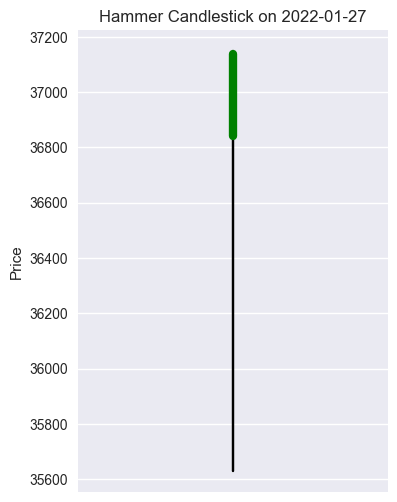

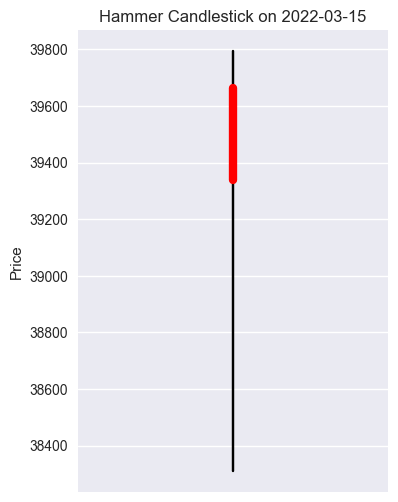

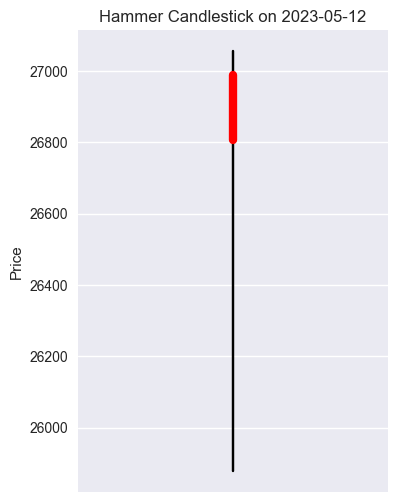

In [118]:
# plotting 3 random hammer candlestick patterns

for idx in random_hammers.index:
    
    plt.figure(figsize=(4,6))
    
    # high-low line
    plt.plot(
        [0, 0],
        [df['Low'].iloc[idx], df['High'].iloc[idx]],
        color='black'
    )
    
    # open-close body
    plt.plot(
        [0, 0],
        [df['Open'].iloc[idx], df['Close'].iloc[idx]],
        linewidth=6,
        color='green' if df['Close'].iloc[idx] > df['Open'].iloc[idx] else 'red'
    )
    
    plt.title(f'Hammer Candlestick on {df['Date'].iloc[idx].date()}')
    plt.xticks([])
    plt.ylabel('Price')
    plt.show()


## 8. Conclusion

The strategy demonstrates rule-based trading using momentum and trend confirmation.
While it underperforms buy-and-hold during strong bull phases, it provides better
downside protection. Candlestick pattern analysis further complements technical insights.
